In [10]:
# ========================================
# IMPORTS
# ========================================

# Librerías Generales
import re
import random
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm

# Librerías de Manejo de Datos y Visualización
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Librerías de Procesamiento de Lenguaje Natural
import nltk
import emoji
import spacy
from wordsegment import load, segment
import nlpaug.augmenter.word as naw

# Librerías de Machine Learning
import tensorflow as tf
from transformers import TFBertModel, BertTokenizer

from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_predict, learning_curve
from sklearn.preprocessing import StandardScaler, LabelEncoder, label_binarize
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_curve, roc_auc_score
)
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import TruncatedSVD
from scipy.sparse import issparse

# Ollama
from ollama import Client


In [6]:
# ========================================
# CONFIGURACION Y CARGA DE DATOS
# ========================================
random_state = 1
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('omw-1.4')
nlp = spacy.load("es_core_news_sm")
load()

df = pd.read_csv("data.csv")
label_encoder = LabelEncoder()
label_encoder.classes_ = np.array(['control', 'anorexia']) 
df['label_enc'] = label_encoder.transform(df['class'])
df.info()
df.describe()
df.head(5)


[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     C:\Users\gusta\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\gusta\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     1500 non-null   object
 1   tweet_id    1500 non-null   object
 2   tweet_text  1500 non-null   object
 3   class       1500 non-null   object
 4   label_enc   1500 non-null   int64 
dtypes: int64(1), object(4)
memory usage: 58.7+ KB


,user_id,tweet_id,tweet_text,class,label_enc
0,user0001,0d3ed29586ce,Cheesecake saludable sin azúcar y sin lactosa ...,control,0
1,user0002,c3cf897a495b,ser como ellas ♡♡\n #HastaLosHuesos,anorexia,1
2,user0003,5041d85c45c6,"Comida Real o , la clave para estar más sana, ...",control,0
3,user0004,d18285d3c7ec,Entre el cambio de hora y la bajada de las #te...,control,0
4,user0005,4d81892f3217,Hace mucho tiempo no sentía mi cuerpo tan frío,anorexia,1


In [7]:
# ========================================
# PREPROCESAMIENTO BETO
# ========================================
tokenizer = BertTokenizer.from_pretrained('dccuchile/bert-base-spanish-wwm-uncased')
model = TFBertModel.from_pretrained('dccuchile/bert-base-spanish-wwm-uncased')

def convert_emojis(text):
    return emoji.demojize(text)

def preprocess_text_bert(text):
    text = convert_emojis(text)
    encoded_input = tokenizer(text, padding=True, truncation=True, max_length=128, return_tensors='tf')
    model_output = model(encoded_input)
    embeddings = model_output.last_hidden_state[:, 0, :].numpy()
    return embeddings.flatten()

print("Procesando embeddings BETO...")
df['tweet_text_beto'] = df['tweet_text'].apply(preprocess_text_bert)
embeddings_matrix = np.stack(df['tweet_text_beto'].values)
embeddings_scaled = StandardScaler().fit_transform(embeddings_matrix)
svd = TruncatedSVD(n_components=50, random_state=random_state)
X_beto = svd.fit_transform(embeddings_scaled)


Some layers from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased were not used when initializing TFBertModel: ['mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFBertModel were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased and are newly initialized: ['bert/pooler/dense/kernel:0', 'bert/pooler/dense/bias:0']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Procesando embeddings BETO...


In [8]:
# ========================================
# PREPROCESAMIENTO NoBETO (BoW)
# ========================================
def split_hashtag(tag):
    tag = tag.lstrip('#')
    camel_split = re.sub(r'(?<=[a-z])(?=[A-Z])', ' ', tag).lower()
    if camel_split == tag.lower():
        try:
            segmented = segment(tag.lower())
            return " ".join(segmented) if segmented else tag.lower()
        except:
            return tag.lower()
    return camel_split

def preprocess_text_no_bert(text):
    text = convert_emojis(text).lower()
    hashtags = re.findall(r"#\w+", text)
    for tag in hashtags:
        text = text.replace(tag, split_hashtag(tag))
    text = re.sub(r"http\S+|www\S+|https\S+", "", text)
    text = re.sub(r"@\w+", "", text)
    text = re.sub(r"\d+", "", text)
    doc = nlp(text)
    lemmatized_words = [token.lemma_ for token in doc if not token.is_stop and not token.is_punct and not token.like_num]
    cleaned = " ".join(lemmatized_words)
    return cleaned


print("Procesando pipeline BoW...")
features = df['tweet_text'].apply(preprocess_text_no_bert)
df['cleaned_tweet'] = features

vectorizer = CountVectorizer(max_features=1000, ngram_range=(1,2))
X_bow = vectorizer.fit_transform(df['cleaned_tweet'])

y = df['label_enc'].values

Procesando pipeline BoW...


In [9]:
# ========================================
# LLAMA VIA OLLAMA (Clasificación Generativa)
# ========================================

ollama_client = Client(host='http://localhost:11434')  # Asegúrate que Ollama esté corriendo

def llama_classify_tweet_generate(text):
    prompt = (
        "A continuación se presenta un tweet escrito en español. Tu tarea es analizarlo cuidadosamente y "
        "determinar si su contenido refleja señales de conductas asociadas a trastornos alimenticios, específicamente anorexia. "
        "Considera el tono emocional, la mención de hábitos alimenticios, el lenguaje corporal implícito o explícito, "
        "y cualquier indicio de preocupación extrema por el peso o la comida.\n"
        f"Tweet: '{text}'\n"
        "¿Este tweet sugiere conductas relacionadas con anorexia?: "
        "Responde únicamente con 1 si detectas evidencia que sugiere tal conducta, o con 0 si no hay indicios suficientes."
    )
    response = ollama_client.generate(model='llama3', prompt=prompt)
    reply = response['response'].strip()
    return 1 if '1' in reply else 0

def classify_all_tweets_parallel(texts, max_workers=4):
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        results = list(tqdm(executor.map(llama_classify_tweet_generate, texts), total=len(texts)))
    return results

print("Clasificando en paralelo...")
df['llama_pred'] = classify_all_tweets_parallel(df['tweet_text'].tolist(), max_workers=6)

#Estimated 50m33s duration

Clasificando en paralelo...


100%|██████████| 1500/1500 [29:24<00:00,  1.18s/it]


In [10]:
# ========================================
# AUGMENTADOR
# ========================================
augmenter = naw.ContextualWordEmbsAug(
    model_path='bert-base-multilingual-uncased',
    action="substitute",
    device='cuda' if tf.config.list_physical_devices('GPU') else 'cpu'
)

def generate_augmented_bow_data(X_texts, y_labels, augment_factor=1):
    aug_texts, aug_labels = [], []
    for i, text in enumerate(X_texts):
        for _ in range(augment_factor):
            try:
                aug = augmenter.augment(text)
            except:
                aug = text
            aug_texts.append(aug)
            aug_labels.append(y_labels[i])
    return aug_texts, aug_labels

# Augmenters configurados (usa español cuando es posible)
syn_aug = naw.SynonymAug(aug_src='wordnet', lang='spa', aug_p=0.3)
swap_aug = naw.RandomWordAug(action="swap", aug_p=0.2)

def augment_text_complex(text, num_augments=1):
    augmented_texts = []
    for _ in range(num_augments):
        aug_type = random.choice(['synonym', 'swap'])
        if aug_type == 'synonym':
            augmented = syn_aug.augment(text)
        elif aug_type == 'swap':
            augmented = swap_aug.augment(text)
        else:
            augmented = text
        if isinstance(augmented, list):
            augmented = augmented[0]
        augmented_texts.append(augmented)
    return augmented_texts

# Expandir el dataset con augmentaciones múltiples por tweet
print("Generando datos aumentados para BoW...")
augmented_texts = []
augmented_labels = []

for text, label in zip(df['cleaned_tweet'], y):
    augmented_versions = augment_text_complex(text, num_augments=2)
    augmented_texts.extend(augmented_versions)
    augmented_labels.extend([label] * len(augmented_versions))

# Dataset extendido: original + aumentados
combined_texts = list(df['cleaned_tweet']) + augmented_texts
combined_labels = list(y) + augmented_labels

# Vectorización y ensamblado con características adicionales
combined_texts = list(df['cleaned_tweet']) + augmented_texts
combined_labels = list(y) + augmented_labels
X_aug_bow = vectorizer.fit_transform(combined_texts)
y_aug_bow = np.array(combined_labels)

# Guardar el dataset aumentado
df_aug = pd.DataFrame({
    'tweet_text': combined_texts,
    'label_enc': combined_labels
})
df_aug.to_csv("augmented_data.csv", index=False)

Generando datos aumentados para BoW...


In [11]:
# ========================================
# FUNCIONES DE EVALUACION CON CV
# ========================================

results_list = []

def plot_confusion_matrix_cv(y_true, y_pred, labels, model_name, pipeline_name, ax):
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels, ax=ax)
    ax.set_title("Confusion Matrix")
    ax.set_xlabel("Predicción")
    ax.set_ylabel("Real")

def plot_roc_curve_cv(model, X, y, cv, ax):
    skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=random_state)
    for i, (train_idx, test_idx) in enumerate(skf.split(X, y)):
        model.fit(X[train_idx], y[train_idx])
        if hasattr(model, "predict_proba"):
            y_score = model.predict_proba(X[test_idx])[:,1]
        else:
            y_score = model.decision_function(X[test_idx])
        y_test_bin = label_binarize(y[test_idx], classes=np.unique(y)).ravel()
        fpr, tpr, _ = roc_curve(y_test_bin, y_score)
        auc = roc_auc_score(y_test_bin, y_score)
        ax.plot(fpr, tpr, label=f"Fold {i+1} (AUC={auc:.2f})")
    ax.plot([0, 1], [0, 1], '--', color='gray')
    ax.set_title("ROC Curve")
    ax.set_xlabel("Falsos Positivos")
    ax.set_ylabel("Verdaderos Positivos")
    ax.grid(True)
    ax.legend(fontsize='small')

def plot_learning_curve_cv(model, X, y, cv, ax):
    train_sizes, train_scores, val_scores = learning_curve(
        model, X, y, train_sizes=np.linspace(0.1, 1.0, 5),
        cv=cv, scoring='f1_weighted', n_jobs=-1
    )
    train_mean, train_std = np.mean(train_scores, axis=1), np.std(train_scores, axis=1)
    val_mean, val_std = np.mean(val_scores, axis=1), np.std(val_scores, axis=1)

    ax.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color='blue')
    ax.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.1, color='orange')
    ax.plot(train_sizes, train_mean, 'o--', color='blue', label='Train Mean')
    ax.plot(train_sizes, val_mean, 'o-', color='orange', label='Val Mean')

    ax.set_title("Learning Curve")
    ax.set_xlabel("Muestras de entrenamiento")
    ax.set_ylabel("F1 Score")
    ax.grid(True)
    ax.legend(fontsize='small')

def evaluate_model_cv(model, param_grid, X, y, model_name, pipeline_name, cv=5):
    print(f"\nEvaluando {model_name} en {pipeline_name} con KFold CV...")

    skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=random_state)
    grid = GridSearchCV(model, param_grid, cv=skf, scoring='f1_weighted', n_jobs=-1)
    grid.fit(X, y)
    best_model = grid.best_estimator_
    y_pred = cross_val_predict(best_model, X, y, cv=skf, n_jobs=-1)

    acc = accuracy_score(y, y_pred)
    prec = precision_score(y, y_pred, average='weighted')
    rec = recall_score(y, y_pred, average='weighted')
    f1 = f1_score(y, y_pred, average='weighted')

    # Subplots: 1 row x 3 cols
    fig, axs = plt.subplots(1, 3, figsize=(15, 4))
    fig.suptitle(f"{model_name} - {pipeline_name}", fontsize=14)

    plot_confusion_matrix_cv(y, y_pred, labels=np.unique(y), model_name=model_name, pipeline_name=pipeline_name, ax=axs[0])
    if len(np.unique(y)) == 2:
        plot_roc_curve_cv(best_model, X, y, cv, ax=axs[1])
    else:
        axs[1].axis('off')  # ROC not applicable
    plot_learning_curve_cv(best_model, X, y, cv, ax=axs[2])

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Leave space for suptitle
    plt.show()

    results_list.append({
        'Pipeline': pipeline_name,
        'Model': model_name,
        'Accuracy': acc,
        'Precision': prec,
        'Recall': rec,
        'F1-Score': f1,
        'Best Params': grid.best_params_
    })



In [12]:
# ========================================
# PARÁMETROS DE GRIDSEARCH
# ========================================

param_grid_lr = {
    'C': [0.01, 0.1, 0.5, 1, 5],
    'penalty': ['l2'],
    'solver': ['lbfgs', 'liblinear'],
    'max_iter': [200, 500]
}
param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20],
    'min_samples_split': [5, 10],
    'min_samples_leaf': [2, 4],
    'max_features': ['sqrt']
}
param_grid_svm = [
    {
        'C': [0.1, 1, 10],
        'kernel': ['linear'],
        'shrinking': [True]
    },
    {
        'C': [0.1, 1, 10],
        'kernel': ['rbf'],
        'gamma': ['scale'],
        'shrinking': [True]
    }
]


=== Evaluando modelos en pipeline: BETO ===

Evaluando Logistic Regression en BETO con KFold CV...


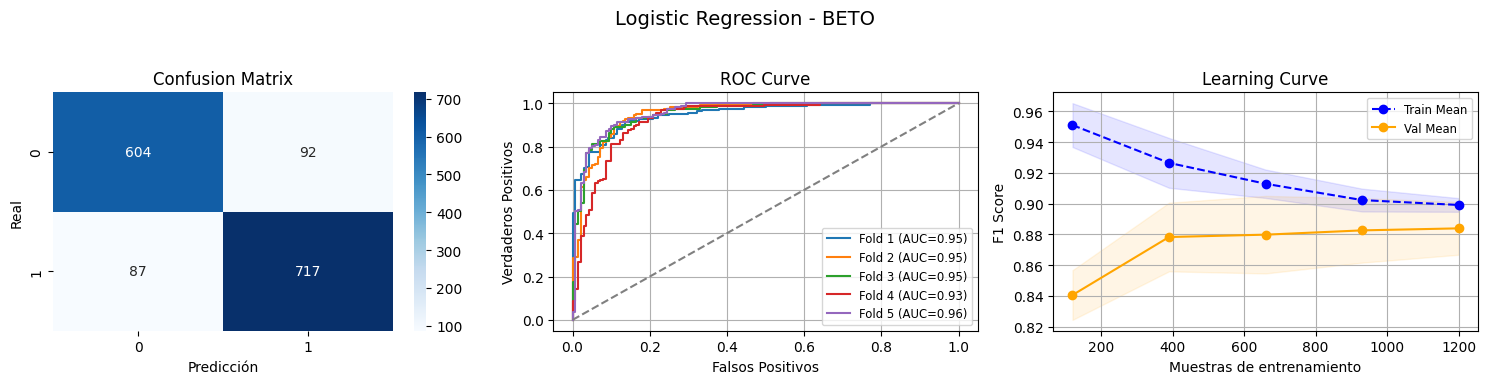


Evaluando Random Forest en BETO con KFold CV...


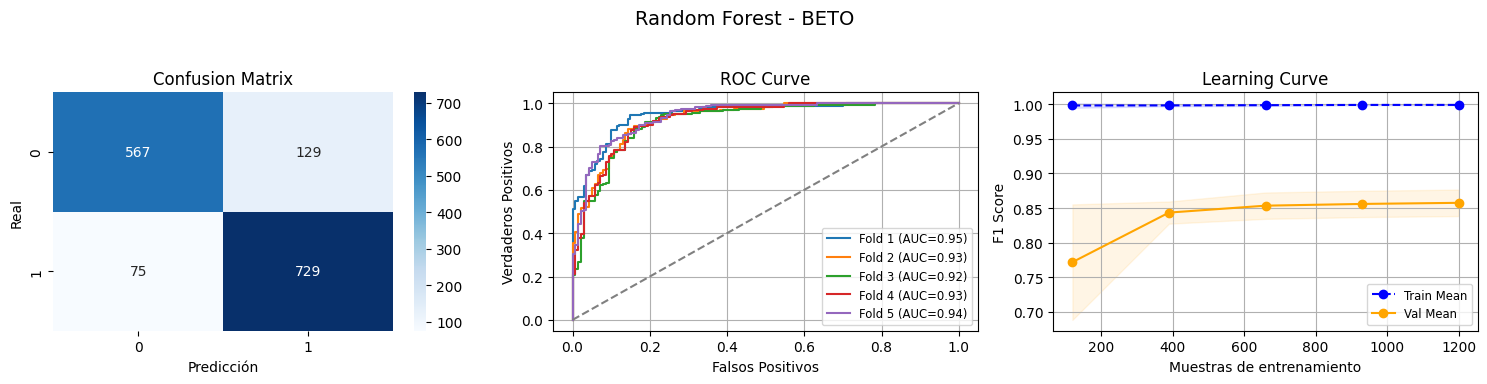


Evaluando SVM en BETO con KFold CV...


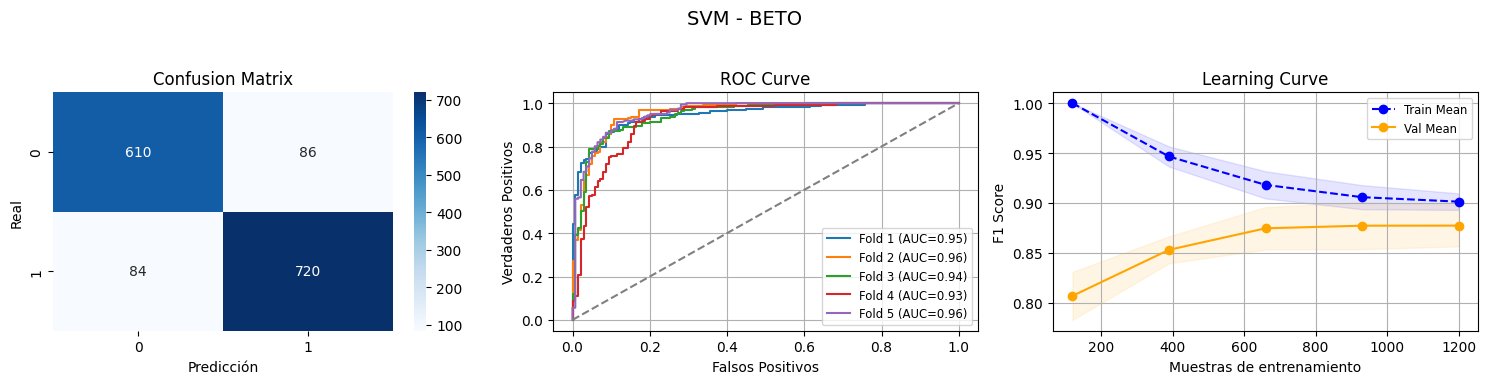

In [13]:
# ========================================
# EVALUACIÓN DEL MODELO BETO
# ========================================
print("\n=== Evaluando modelos en pipeline: BETO ===")
X_beto_input = X_beto if not issparse(X_beto) else X_beto.tocsr()
for model, name, param_grid in [
    (LogisticRegression(random_state=random_state), "Logistic Regression", param_grid_lr),
    (RandomForestClassifier(random_state=random_state), "Random Forest", param_grid_rf),
    (SVC(probability=True, random_state=random_state), "SVM", param_grid_svm)
]:
    evaluate_model_cv(model, param_grid, X_beto_input, y, name, "BETO")



=== Evaluando modelos en pipeline: BoW ===

Evaluando Logistic Regression en BoW con KFold CV...


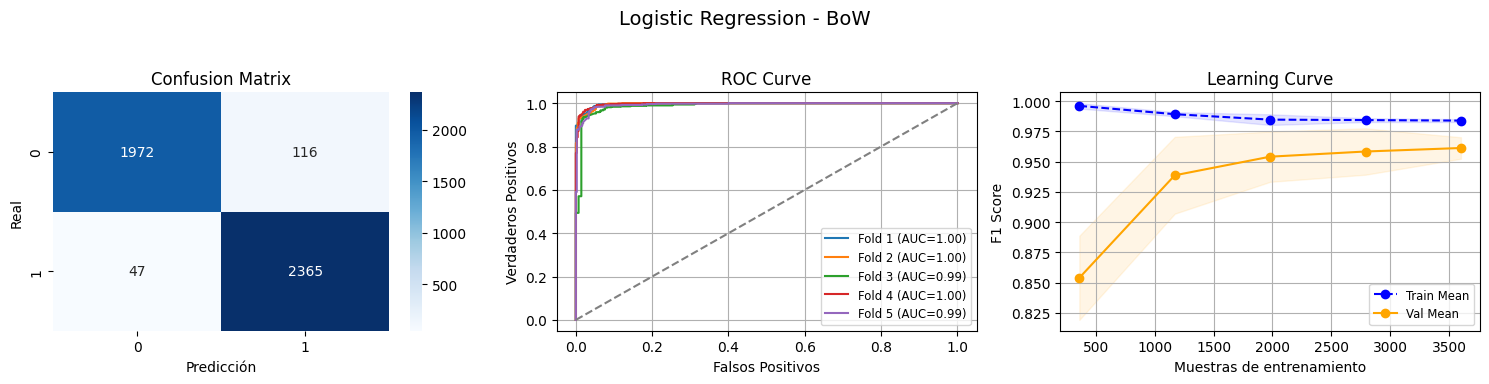


Evaluando Random Forest en BoW con KFold CV...


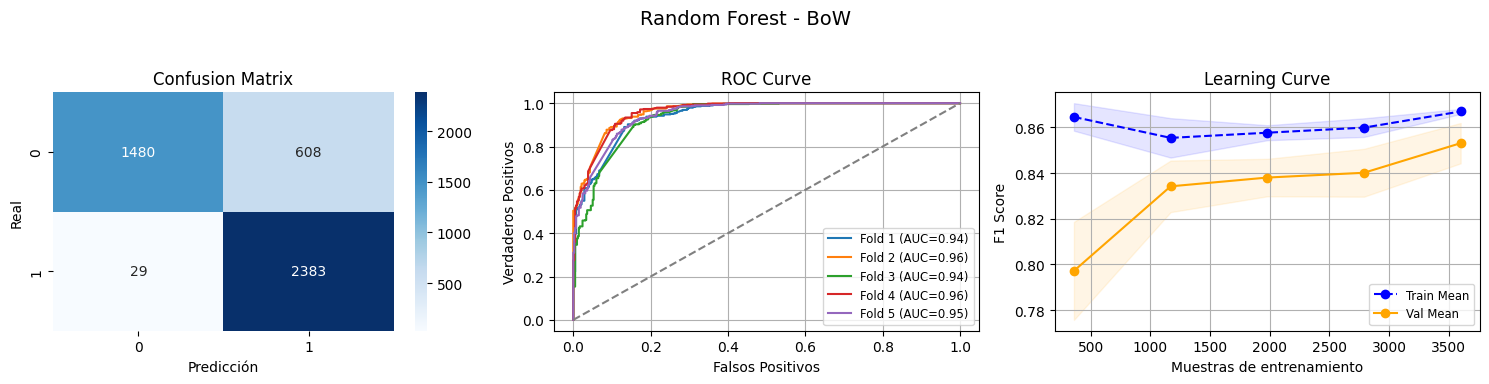


Evaluando SVM en BoW con KFold CV...


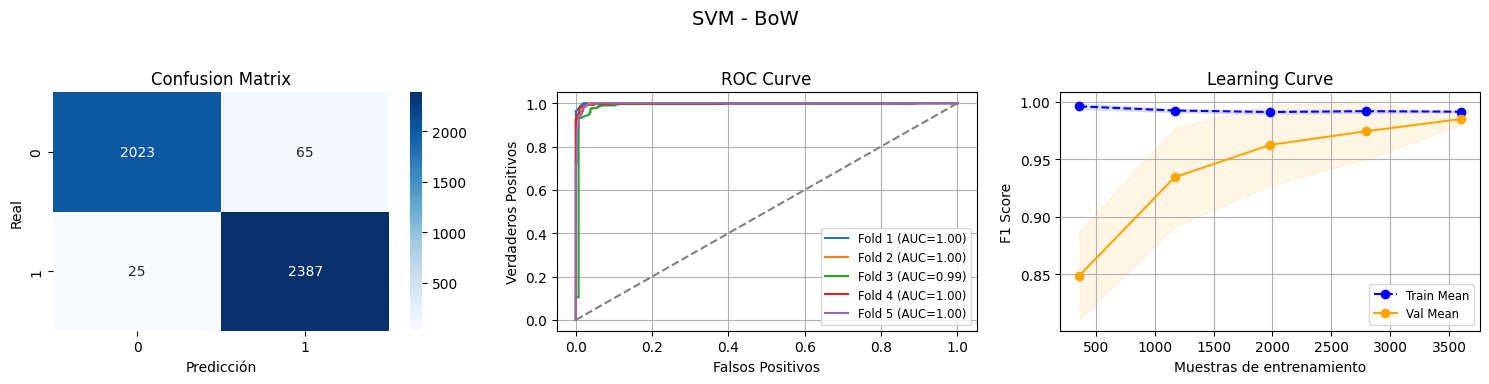

In [14]:
# ========================================
# EVALUACIÓN DEL MODELO BoW
# ========================================
print("\n=== Evaluando modelos en pipeline: BoW ===")
X_bow_input = X_aug_bow if not issparse(X_aug_bow) else X_aug_bow.tocsr()
for model, name, param_grid in [
    (LogisticRegression(random_state=random_state), "Logistic Regression", param_grid_lr),
    (RandomForestClassifier(random_state=random_state), "Random Forest", param_grid_rf),
    (SVC(probability=True, random_state=random_state), "SVM", param_grid_svm)
]:
    evaluate_model_cv(model, param_grid, X_bow_input, y_aug_bow, name, "BoW")


Evaluando LLaMA con clasificación generativa...


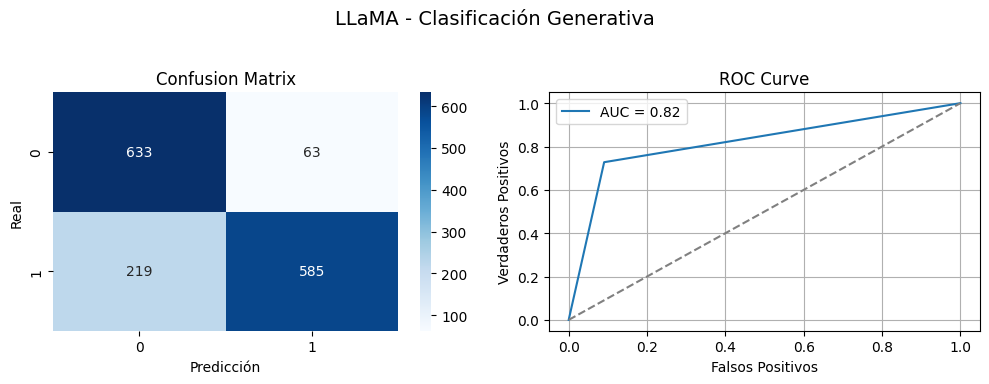

In [15]:
# ========================================
# EVALUACIÓN DEL MODELO LLaMA
# ========================================
print("\nEvaluando LLaMA con clasificación generativa...")

# Asegurar consistencia de etiquetas (1 = conducta asociada a anorexia)
if label_encoder.classes_[0] == 'T':  # T se codificó como 0, invertir
    y_true_llama = 1 - df['label_enc'].values
else:
    y_true_llama = df['label_enc'].values

y_llama_pred = df['llama_pred'].values

# Métricas
acc = accuracy_score(y_true_llama, y_llama_pred)
prec = precision_score(y_true_llama, y_llama_pred, average='weighted')
rec = recall_score(y_true_llama, y_llama_pred, average='weighted')
f1 = f1_score(y_true_llama, y_llama_pred, average='weighted')

# Gráficas
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
fig.suptitle("LLaMA - Clasificación Generativa", fontsize=14)

# Confusion Matrix
plot_confusion_matrix_cv(
    y_true_llama,
    y_llama_pred,
    labels=[0, 1],
    model_name="LLaMA",
    pipeline_name="Generativo",
    ax=axs[0]
)

# ROC Curve
if len(np.unique(y_true_llama)) == 2:
    y_true_bin = label_binarize(y_true_llama, classes=[0, 1]).ravel()
    fpr, tpr, _ = roc_curve(y_true_bin, y_llama_pred)
    auc = roc_auc_score(y_true_bin, y_llama_pred)

    axs[1].plot(fpr, tpr, label=f"AUC = {auc:.2f}")
    axs[1].plot([0, 1], [0, 1], '--', color='gray')
    axs[1].set_title("ROC Curve")
    axs[1].set_xlabel("Falsos Positivos")
    axs[1].set_ylabel("Verdaderos Positivos")
    axs[1].grid(True)
    axs[1].legend()
else:
    axs[1].axis('off')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# Registrar resultados
results_list.append({
    'Pipeline': 'LLaMA',
    'Model': 'Generativo',
    'Accuracy': acc,
    'Precision': prec,
    'Recall': rec,
    'F1-Score': f1,
    'Best Params': 'N/A'
})

In [16]:
# ========================================
# RESUMEN DE RESULTADOS
# ========================================

df_results = pd.DataFrame(results_list)
print("\nResumen de resultados:") 
print(df_results.sort_values(by='F1-Score', ascending=False).to_string(index=False))



Resumen de resultados:
Pipeline               Model  Accuracy  Precision   Recall  F1-Score                                                                                                    Best Params
     BoW                 SVM  0.980000   0.980127 0.980000  0.979986                                                {'C': 10, 'gamma': 'scale', 'kernel': 'rbf', 'shrinking': True}
     BoW Logistic Regression  0.963778   0.964138 0.963778  0.963729                                              {'C': 5, 'max_iter': 200, 'penalty': 'l2', 'solver': 'liblinear'}
    BETO                 SVM  0.886667   0.886648 0.886667  0.886656                                                                {'C': 1, 'kernel': 'linear', 'shrinking': True}
    BETO Logistic Regression  0.880667   0.880626 0.880667  0.880637                                               {'C': 0.01, 'max_iter': 200, 'penalty': 'l2', 'solver': 'lbfgs'}
    BETO       Random Forest  0.864000   0.865207 0.864000  0.863465  {'max_